# Dependancies

In [31]:
import gpxpy
import gpxpy.gpx

import glob

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from geopy.distance import distance
from geopy.distance import geodesic
from geopy import distance
import math

import haversine as hs
import numpy as np

import datetime
from time import strftime
from time import gmtime

import folium
from folium.features import DivIcon

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from IPython.display import display

# Enter one route

In [205]:
name = 'vhtrc-waterfall-50k'

with open('Routes/'+name+'.gpx', 'r') as gpx_file:
    route = gpxpy.parse(gpx_file)

In [206]:
# making a dictionary that can be converted to Pandas Dataframe
route_info=[]

for track in route.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                'time': point.time,
                'latitude': point.latitude,
                'longitude':point.longitude,
                'elevation': point.elevation
            })

df = pd.DataFrame(route_info)

# All together

In [35]:
# name = 'vhtrc-mmt-training-two-2021'

files = glob.glob('Routes/*.gpx')
df_list=[]
for f in files:
    with open(f, 'r') as gpx_file:
        route = gpxpy.parse(gpx_file)
    
    # making a dictionary that can be converted to Pandas Dataframe
    route_info=[]

    for track in route.tracks:
        for segment in track.segments:
            for point in segment.points:
                route_info.append({
                    'time': point.time,
                    'latitude': point.latitude,
                    'longitude':point.longitude,
                    'elevation': point.elevation
                })
    df_list.append(f[7:-4])

    df = pd.DataFrame(route_info)
    pointxyz = []
    for i in range(0,len(df)):
        pointxyz.append((df['latitude'][i], df['longitude'][i], df['elevation'][i]))

    df['pointxyz']= pd.Series(pointxyz)

    def haversine_distance(lat1, lon1, lat2, lon2) -> float:
        distance = hs.haversine(
            point1=(lat1,lon1),
            point2=(lat2,lon2),
            unit=hs.Unit.MILES
        )
        return np.round(distance,8)

    distances = [np.nan]
    cap_mph = 10
    distance_cap = 1/(60/cap_mph*60)

    for i in range(len(df)):
        if i == 0:
            continue
        else:
            unit_dist = haversine_distance(
                lat1=df.iloc[i - 1]['latitude'],
                lon1=df.iloc[i - 1]['longitude'],
                lat2=df.iloc[i]['latitude'],
                lon2=df.iloc[i]['longitude']
            )
            # if unit_dist > distance_cap:
            #     distances.append(np.nan)
            # else:
            distances.append(unit_dist)

    df['distance'] = distances
    df['distance'] = df['distance'].interpolate().fillna(0)

    df['elevation_change'] = df['elevation'].diff()
    df['cum_elevation'] = df['elevation_change'].cumsum()
    df['cum_distance'] = df['distance'].cumsum()
    # df = df.fillna(0)

    df['step_feet'] = df['distance'] * 5280

    grade_cap_high = 30
    conversion_factor = 0.62137119
    gradient_point =[np.nan]
    for ind, row in df.iterrows():
        if ind == 0:
            continue
        grade = (row['elevation_change'] / ((row['distance']/conversion_factor*1000)+1))*100
        if abs(grade) > grade_cap_high :
            gradient_point.append(np.nan)
        else:
            gradient_point.append(np.round(grade,1))

    df['gradient_point'] = gradient_point
    df['gradient_point'] = df['gradient_point'].interpolate().fillna(0)

    # bin the gradients
    bin_labels_cut = ['bigDown', 'down', 'flat', 'up', 'bigUp']
    bin_cuts=[-30, -15, -5, 5, 15, 30]
    df['gradient_rating'] = pd.cut(df['gradient_point'],
                                bins=bin_cuts,
                                labels=bin_labels_cut)

    df.to_csv('data/route_csv/'+f[7:-4]+'.csv', index=False)
    
df_list_dict = {'races':df_list}
dfdf_list = pd.DataFrame(df_list_dict) 
dfdf_list.to_csv('data/df_list.csv', index=False)
df_list

['twot-2013',
 'vickis-death-march',
 'DD100K_2021',
 '2-loop_mtvernon',
 'vhtrc-waterfall-50k',
 'vhtrc-reverse-ring',
 'vhtrc-mmt-training-two-2021',
 'Elizabeths_Furnace',
 'holy-cowans-gap',
 'vhtrc-catherines-50km',
 'vhtrc-martha-moats-baker',
 'vhtrc-ring',
 'the-big-schloss',
 'pb_j_50_km_2019',
 'qs_quad_busters-2015',
 'vhtrc-mgm-50km',
 'vhtrc-boyers-furnace',
 'vhtrc-redeye-2018',
 'vhtrc-mmt-training-one',
 'vhtrc-chocolate-bunny',
 'VHTRC_Hashahwha_Hills_50k',
 'Quarantine-Puppy-50k-Loop']

# Elevation plot

In [9]:
df_1 = pd.read_csv('data/route_csv/Elizabeths_Furnace.csv')
df_2 = pd.read_csv('data/route_csv/vhtrc-waterfall-50k.csv')
df_ring = pd.read_csv('data/route_csv/vhtrc-ring.csv')
df_dd = pd.read_csv('data/route_csv/DD100K_2021.csv')



In [16]:
df_total = df_1[['cum_distance','cum_elevation']].head()
df_total['name'] = 'test'
df_total

,cum_distance,cum_elevation,name
0,0.000000,NaN,test
1,0.002335,0.360290,test
2,0.006147,0.936630,test
3,0.018850,2.433166,test
4,0.028731,3.633209,test


In [29]:
race_total = pd.DataFrame([[1, 2,3]], columns=['cum_elevation', 'cum_distance','race'])
race_total

,cum_elevation,cum_distance,race
0,1,2,3


In [30]:
# Elevations for all the dfs


col_list = ['cum_elevation', 'cum_distance','race']


race_total = race_total = pd.DataFrame([[1, 2,3]], columns=col_list)
for r in df_list:
    rdf = pd.read_csv('data/route_csv/'+r+'.csv')
    race_info = rdf[['cum_distance','cum_elevation']]
    race_info['race'] = r
    race_total.append(race_info)
    
race_total.head()
    


NameError: name 'df_list' is not defined

In [ ]:
all_race_elevation = pd.DataFrame.from_dict(all_elev_dict,orient ='index',columns=col_list)
all_race_elevation

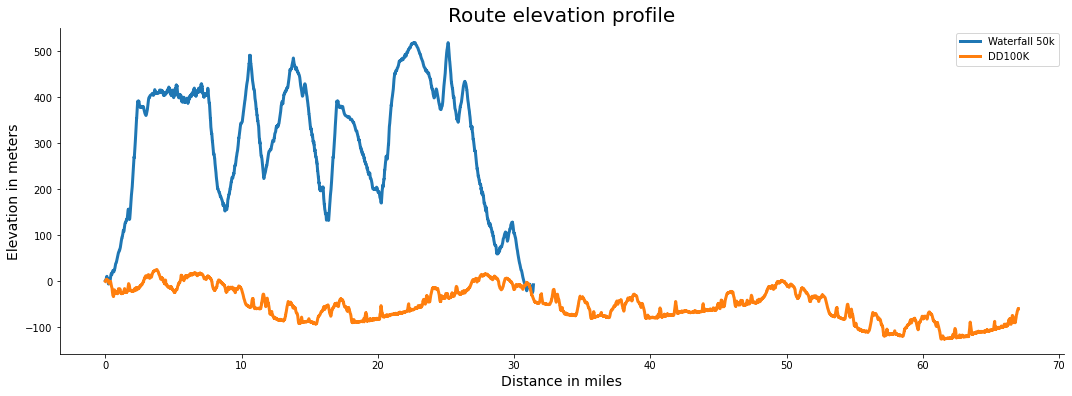

In [8]:
plt.figure(figsize=(18,6))
# plt.plot(df_1['cum_distance'], df_1['cum_elevation'], label= "Elizabeths Furnace",  lw=3)
plt.plot(df_2['cum_distance'], df_2['cum_elevation'], label = 'Waterfall 50k',  lw=3)
# plt.plot(df_ring['cum_distance'], df_ring['cum_elevation'], label = 'The Ring',  lw=3)
plt.plot(df_dd['cum_distance'], df_dd['cum_elevation'], label = 'DD100K',  lw=3)



plt.title('Route elevation profile', size=20)
plt.legend()
plt.xlabel('Distance in miles', size=14)
plt.ylabel('Elevation in meters', size=14);

# Miler Markers on route

In [107]:
def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return [lowerneighbour_ind, upperneighbour_ind] 

def make_mile_segments(row):
    return row['cum_distance']//1 +1
df['mile_num'] = df.apply(make_mile_segments, axis=1)

# find the begining location of each mile
def mile_marker_loc(df):
    mile_markers = []

    for i in range(1,len(df['mile_num'].unique())):
        junder,jover  = find_neighbours(i, df, 'cum_distance')
        mile_markers.append(jover)
    return mile_markers

def number_DivIcon(color,number):
    """ Create a 'numbered' icon
    
    """
    icon = DivIcon(
            icon_size=(150,36),
            icon_anchor=(14,40),
#             html='<div style="font-size: 18pt; align:center, color : black">' + '{:02d}'.format(num+1) + '</div>',
            html="""<span class="fa-stack " style="font-size: 12pt" >>
                    <!-- The icon that will wrap the number -->
                    <span class="fa fa-circle-o fa-stack-2x" style="color : {:s}"></span>
                    <!-- a strong element with the custom content, in this case a number -->
                    <strong class="fa-stack-1x">
                        {:02d}  
                    </strong>
                </span>""".format(color,number)
        )
    return icon
    
col_hex = ['#440154',
 '#481a6c',
 '#472f7d',
 '#414487',
 '#39568c',
 '#31688e',
 '#2a788e',
 '#23888e',
 '#1f988b',
 '#22a884',
 '#35b779',
 '#54c568',
 '#7ad151',
 '#a5db36',
 '#d2e21b']

# Graph mile markers on map with mile time on click - folium
lat_map = df['latitude'].mean()
lon_map = df['longitude'].mean()
route_map = folium.Map(
    location=[lat_map, lon_map],
    zoom_start=13,
    tiles='OpenStreetMap',
    width= 1000,
    height=800
)
coordinates = [tuple(x) for x in df[['latitude','longitude']].to_numpy()]
folium.PolyLine(coordinates, weight=6).add_to(route_map)

# find mile markers
locations_to_chart = mile_marker_loc(df)
# find mile times
# mile_times = run_miles(df)
num =0
mile=1

for i in locations_to_chart:
    mile_hex = mile//15+1
    loc = [df['latitude'][i], df['longitude'][i]]
    folium.Marker(
        location=loc,
        popup="Mile " + '{:02d}'.format(mile),
        icon=folium.Icon(color='white',icon_color='white'),
        markerColor=col_hex[mile_hex]
    ).add_to(route_map)

    # folium.Marker(
    #     location=loc,
    #     popup="Mile " + '{:02d}'.format(mile)+ " "+ mile_times[mile-1],
    #     icon= number_DivIcon(col_hex[mile_hex],mile)
    # ).add_to(route_map)
    # mile+=1

    folium.Marker(
        location=loc,
        popup="Mile " + '{:02d}'.format(mile),
        icon= number_DivIcon(col_hex[mile_hex],mile)
    ).add_to(route_map)
    mile+=1



display(route_map)

# Gradient Calculations

In [181]:
df.head()

,time,latitude,longitude,elevation,pointxyz,distance,elevation_change,cum_elevation,cum_distance,step_feet
0,None,38.55856,-77.34291,60.03,"(38.55856, -77.34291, 60.03000000000001)",0.000000,NaN,NaN,0.000000,0.000000
1,None,38.55851,-77.34308,59.79,"(38.558510000000005, -77.34308, 59.79)",0.009813,-0.24,-0.24,0.009813,51.813485
2,None,38.55853,-77.34335,59.08,"(38.558530000000005, -77.34335, 59.08000000000...",0.014653,-0.71,-0.95,0.024466,77.368738
3,None,38.55856,-77.34344,58.70,"(38.55856, -77.34344, 58.7)",0.005286,-0.38,-1.33,0.029752,27.909974
4,None,38.55863,-77.34357,58.70,"(38.55863, -77.34357, 58.7)",0.008528,0.00,-1.33,0.038280,45.027470


# Make DataFrame of all the routes

In [215]:
# just on one df
how_run_grade2 =[]
grade_labels2 = []

diff_grades = df['gradient_rating'].unique()
for i in diff_grades:
    how_run_grade2.append(np.round(df[df['gradient_rating'] == i]['distance'].sum(),2))
    grade_labels2.append(i)
how_run_grade2.append(np.round(df['distance'].sum(),2))
grade_labels2.append('Total_Distance')
dict_list ={}
for i in how_run_grade2:
    dict_list[name] = how_run_grade2

test_df = pd.DataFrame.from_dict(dict_list,orient ='index',columns=grade_labels2)
test_df
# print(how_run_grade2)
# print(grade_labels2)

,flat,up,down,bigUp,bigDown,Total_Distance
vhtrc-waterfall-50k,7.78,1.21,1.29,0.13,0.14,10.53


In [220]:
# all the dfs
turn = 0
all_race_dict ={}
grade_labels_it = ['flat', 'up', 'down', 'bigUp', 'bigDown']
grade_labels3 = ['flat', 'up', 'down', 'bigUp', 'bigDown', 'Total_Distance']
all_elev_dict ={}
col_list = ['cum_elevation', 'cum_distance']


for r in df_list:
    rdf = pd.read_csv('data/route_csv/'+r+'.csv')
    how_run_grade3 =[]
    # diff_grades = rdf['gradient_rating'].unique()
    for i in grade_labels_it:
        how_run_grade3.append(np.round(rdf[rdf['gradient_rating'] == i]['distance'].sum(),2))
    how_run_grade3.append(np.round(rdf['distance'].sum(),2))
    
    
    for i in how_run_grade3:
        all_race_dict[r] = how_run_grade3

    
    turn +=1



In [222]:
# all_race_dict
# print(grade_labels3)
all_race_df = pd.DataFrame.from_dict(all_race_dict,orient ='index',columns=grade_labels3)
all_race_df

,flat,up,down,bigUp,bigDown,Total_Distance
twot-2013,8.51,5.98,6.51,3.52,3.43,27.94
vickis-death-march,9.14,5.62,5.81,2.27,2.41,25.25
DD100K_2021,40.51,12.02,12.84,0.71,0.94,67.02
2-loop_mtvernon,6.27,0.95,1.02,0.08,0.09,8.41
vhtrc-waterfall-50k,11.92,6.64,7.08,2.80,2.98,31.42
vhtrc-reverse-ring,27.89,15.83,15.65,5.26,5.44,70.06
vhtrc-mmt-training-two-2021,9.94,5.73,5.63,1.89,2.16,25.35
Elizabeths_Furnace,10.42,6.81,7.22,3.06,3.04,30.55
holy-cowans-gap,8.74,6.66,7.05,4.32,5.11,31.87
vhtrc-catherines-50km,11.19,7.19,7.11,2.11,2.35,29.95
